In [1]:
# This is the poop-mans version for installing proper - better to use the install script. 
# Note pyfits must also be installed (pip install pyfits)
import sys
sys.path.insert(0, '../../proper_v3.0a_python_22jan18/')

## PROPER HST example

Taken from `proper/examples/hubble_simple.py`

In [2]:
#   Copyright 2016, 2017 California Institute of Technology
#   Users must agree to abide by the restrictions listed in the
#   file "LegalStuff.txt" in the PROPER library directory.
#
#   PROPER developed at Jet Propulsion Laboratory/California Inst. Technology
#   Original IDL version by John Krist
#   Python translation by Navtej Saini, with Luis Marchen and Nikta Amiri

import proper


def hubble_simple(wavelength, gridsize, PASSVALUE = {'delta_sec': 0.}):
    # Define entrance aperture diameter and other quantities
    diam = 2.4                                 # telescope diameter in meters
    fl_pri = 5.52085                           # HST primary focal length (m)
    d_pri_sec = 4.907028205                    # primary to secondary separation (m)
    fl_sec = -0.6790325                        # HST secondary focal length (m)
    d_sec_to_focus = 6.3919974                 # nominal distance from secondary to focus
    beam_ratio = 0.5                           # initial beam width/grid width

    # delta_sec = additional primary-to-secondary separation offset (m)
    delta_sec = PASSVALUE['delta_sec']

    # Define the wavefront
    wfo = proper.prop_begin(diam, wavelength, gridsize, beam_ratio)

    # Define a circular aperture
    proper.prop_circular_aperture(wfo, diam/2)                        # HST aperture (primary mirror)
    proper.prop_circular_obscuration(wfo, 0.396)                      # secondary mirror obscuration
    proper.prop_rectangular_obscuration(wfo, 0.0264, 2.5)             # secondary vane (vertical)
    proper.prop_rectangular_obscuration(wfo, 2.5, 0.0264)             # secondary vane (horizontal)
    proper.prop_circular_obscuration(wfo, 0.078, -0.9066, -0.5538)    # primary mirror pad 1
    proper.prop_circular_obscuration(wfo, 0.078, 0., 1.0705)          # primary mirror pad 2
    proper.prop_circular_obscuration(wfo, 0.078, 0.9127, -0.5477)     # primary mirror pad 3 

    # Define entrance
    proper.prop_define_entrance(wfo)

    # Define a lens
    proper.prop_lens(wfo, fl_pri, "primary")                          # primary mirror

    # Propagate the wavefront
    proper.prop_propagate(wfo, d_pri_sec+delta_sec, "secondary")

    proper.prop_lens(wfo, fl_sec, "secondary")

    proper.prop_propagate(wfo, d_sec_to_focus+delta_sec, "HST focus", TO_PLANE = False)

    # End
    (wfo, sampling) = proper.prop_end(wfo)

    return (wfo, sampling)

/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


Applying lens at primary
Propagating to secondary
Applying lens at secondary
Propagating to HST focus


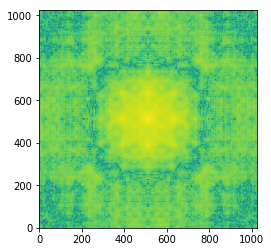

In [3]:
import numpy as np  
import matplotlib.pylab as plt  
(psf, sampling) = hubble_simple(wavelength=0.6, gridsize=1024, PASSVALUE = {'delta_sec': 0.})

plt.imshow(np.log10(psf), origin = 'lower')  
plt.show()  


## Adapt to TOLIMAN configuration

In [7]:
import proper
import math


def toliman_simple(wavelength, gridsize):
    # Values from Eduardo's RC Toliman system
    diam = 0.3                               # telescope diameter in meters
    fl_pri = 0.5*1.143451                    # primary focal length (m)
    d_pri_sec = 0.559337630333726            # primary to secondary separation (m)
    fl_sec = -0.5*0.0467579189727913         # secondary focal length (m)
    d_sec_to_focus = 0.589999999989853       # nominal distance from secondary to focus
    beam_ratio = 0.5                         # initial beam width/grid width

    # Values from Eduardo's RC Toliman system
#diam = 0.3 * u.m
#m1_fl = 0.5*1.143451 * u.m
#m1_m2_sep = 0.559337630333726 * u.m
#m2_fl = -0.5*0.0467579189727913 * u.m
#m2_focus_sep = 0.589999999989853 * u.m # 0.018 * u.m
    m2_rad = 0.059 # Secondary half-diameter (m)
    m2_strut_width = 0.01 # Width of struts supporting M2 (m)
    m2_supports = 5
#epsilon = 0.0 * u.m

    # Define the wavefront
    wfo = proper.prop_begin(diam, wavelength, gridsize, beam_ratio)
    
    # Input aperture
    proper.prop_circular_aperture(wfo, diam/2)
    # NOTE: could prop_propagate() here if some baffling included
    # Secondary and structs obscuration
    proper.prop_circular_obscuration(wfo, m2_rad)                      # secondary mirror obscuration
    # Spider struts/vanes, arranged evenly radiating out from secondary
    strut_length = diam/2 - m2_rad
    strut_step = 360/m2_supports
    strut_centre = m2_rad + strut_length/2
    for i in range(0, m2_supports):
        angle = i*strut_step
        radians = math.radians(angle) 
        xoff = math.cos(radians)*strut_centre
        yoff = math.sin(radians)*strut_centre
        proper.prop_rectangular_obscuration(wfo, m2_strut_width, strut_length,
                                            xoff, yoff,
                                            ROTATION = angle)
        
    # Define entrance
    proper.prop_define_entrance(wfo)

    # Primary mirror (treat as quadratic lens)
    proper.prop_lens(wfo, fl_pri, "primary")

    # Propagate the wavefront
    proper.prop_propagate(wfo, d_pri_sec, "secondary")

    # Secondary mirror (another quadratic lens)
    proper.prop_lens(wfo, fl_sec, "secondary")
    
    # NOTE: hole through primary?

    # Focus
    proper.prop_propagate(wfo, d_sec_to_focus, "focus", TO_PLANE = False)

    # End
    (wfo, sampling) = proper.prop_end(wfo)

    return (wfo, sampling)


Applying lens at primary
Propagating to secondary
Applying lens at secondary
Propagating to focus


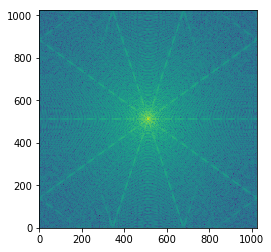

In [8]:
import numpy as np  
import matplotlib.pylab as plt  
(psf, sampling) = toliman_simple(wavelength=0.6, gridsize=1024)

plt.imshow(np.log10(psf), origin = 'lower')  
plt.show()  
